In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lstm_sine import SineData
import warnings

In [2]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [3]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    print("Gpu not found")
    device = "cpu"

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, nodes=10, layers=1, memory=15, dropout=0, dual_gpu=True):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        ).to(device)
        if dual_gpu:
            self.lstm = nn.DataParallel(
                self.lstm, device_ids=["cuda:0", "cuda:1"], output_device=device
            )
        self.out = nn.Linear(nodes, 1).to(device)

    def forward(self, x, future=0):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            output, (h_n, c_n) = self.lstm(x)
            if future == 0:
                return self.out(h_n[-1])
            else:
                out = self.out(h_n[-1])
                out = out.view(1, *out.size())
                out_series = torch.zeros((future, *out.size())).to(device)
                out_series[0] = out[:, :, :]
                # print(f"i=0: y:{out_series[0].size()} h0:{h_n.size()} c0:{c_n.size()}")
                del out
                for i in range(1, future):
                    # print(
                    #    f"i={i}: y:{out_series[i].size()} h0:{h_n.size()} c0:{c_n.size()}"
                    # )
                    output, (h_n, c_n) = self.lstm(out_series[i - 1], (h_n, c_n))
                    out_series[i] = self.out(h_n[-1]).view(*out_series[i - 1].size())
            return out_series.view(
                out_series.size(0), out_series.size(2), out_series.size(3)
            )

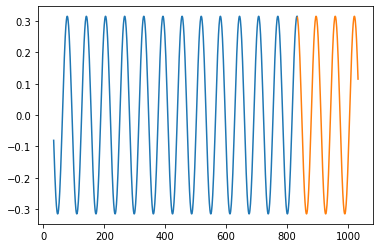

In [5]:
waves = 300
test = int(0.25 * waves)
f = 100
sample = 1000
future = 200
T = sample / f
if future >= sample:
    raise ValueError("Increase sample to be > future!")
# x =  torch.from_numpy(np.swapaxes( np.arange(0, sample) + np.zeros((waves, sample)),0,1)[:, :, np.newaxis]).float().to(device)
x = (
    torch.from_numpy(
        np.swapaxes(
            np.arange(0, sample) + np.random.randint(-4 * T, 4 * T, size=(waves, 1)),
            0,
            1,
        )[:, :, np.newaxis]
    )
    .float()
    .to(device)
)

x_test = x[:, :test]
x = x[:, test:]

x_future = x[-future:]
x = x[:-future]
# with torch.no_grad():
random_amps = (
    torch.from_numpy(
        (10 ** (np.random.uniform(np.log10(0.1), np.log10(2), size=[waves, 1])))
    )
    .float()
    .to(device)
)
y_future = torch.sin(x_future / T) * random_amps[test:]
y = torch.sin(x / T) * random_amps[test:]
y_test = torch.sin(x_test / T) * random_amps[:test]
plt.plot(x.cpu().detach()[:, 0], y.cpu().detach()[:, 0])
plt.plot(x_future.cpu().detach()[:, 0], y_future.cpu().detach()[:, 0])
plt.show()

In [6]:
%%time
model = LSTMModel(nodes=51, layers=3, dropout=0, dual_gpu=False).to(device)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = nn.MSELoss()
model.train()

for i in range(40):

    def closure():
        optimizer.zero_grad()
        y_pred = model.forward(y[:-1])
        loss = loss_func(y_pred, y[-1])
        print(f"Epoch {i}: {loss.item()}")
        loss.backward()
        return loss
    optimizer.step(closure)

Epoch 0: 0.40601494908332825
Epoch 0: 0.4057133197784424
Epoch 0: 0.4051896929740906
Epoch 0: 0.40465518832206726
Epoch 0: 0.4041072130203247
Epoch 0: 0.4035424590110779
Epoch 0: 0.4029572308063507
Epoch 0: 0.40234705805778503
Epoch 0: 0.4017065763473511
Epoch 0: 0.40102967619895935
Epoch 0: 0.40030908584594727
Epoch 0: 0.3995361328125
Epoch 0: 0.39870044589042664
Epoch 0: 0.3977891206741333
Epoch 0: 0.39678555727005005
Epoch 0: 0.39566776156425476
Epoch 0: 0.39440450072288513
Epoch 0: 0.3929489552974701
Epoch 0: 0.39122533798217773
Epoch 0: 0.38909912109375
Epoch 1: 0.38629719614982605
Epoch 1: 0.38213005661964417
Epoch 1: 0.3738594353199005
Epoch 1: 0.34045615792274475
Epoch 1: 0.3340000510215759
Epoch 1: 0.3268618881702423
Epoch 1: 4.590695858001709
Epoch 1: 4.099899768829346
Epoch 1: 3.340965747833252
Epoch 1: 2.0213723182678223
Epoch 1: 1.4499233961105347
Epoch 1: 1.2141274213790894
Epoch 1: 1.0520340204238892
Epoch 1: 0.9221063256263733
Epoch 1: 0.8148605823516846
Epoch 1: 0.7251

In [7]:
# sample_plot = 2
def pred(y, y_future, model=model):
    with torch.no_grad():
        batch = y.size(1)
        future = y_future.size(0)
        y_pred = torch.zeros(y.size(0) + future, batch, 1, device=device)
        y_pred[: y.size(0)] = y
        y_pred[y.size(0) :] = model.forward(y, future=future)
        print(
            f"With {future} predicted points on a batch of {waves-test} we get a loss of {loss_func(y_pred[y.size(0):], y_future):.2e}"
        )
        y_pred = y_pred.cpu().detach()
        return y_pred

In [8]:
y_pred = pred(y, y_future)

With 200 predicted points on a batch of 225 we get a loss of 3.86e-04


In [9]:
def plot(x, x_future, y, y_future, y_pred, rows=2, plots=4, filename=None):
    plot_indices = np.random.choice(
        np.arange(y_pred.size(1)), size=[plots], replace=False
    )
    fig, ax = plt.subplots(
        plots // rows, rows, figsize=[10, 10], sharex=True, sharey=True
    )
    ax = ax.flatten()
    # print(len(ax), waves)
    for i, index in enumerate(plot_indices):
        ax[i].plot(x[:, index].cpu().detach(), y_pred[: y.size(0), index], color="blue")
        ax[i].plot(
            x_future[:, index].cpu().detach(),
            y_pred[y.size(0) :, index],
            color="yellow",
        )
        ax[i].plot(
            x_future[:, index].cpu().detach(),
            y_future[:, index].cpu().detach(),
            ":",
            color="black",
        )
    fig.legend(["Input", "Output", "True output"])
    fig.suptitle(f"{plots} randomly selected extrapolation plots.", size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    if filename:
        fig.savefig(filename, dpi=1000)
    plt.show()

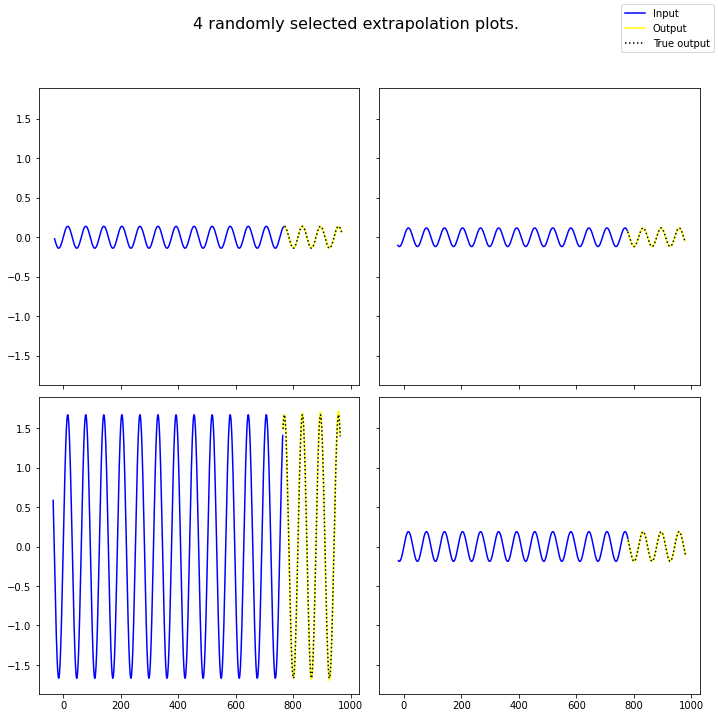

In [10]:
plot(x, x_future, y, y_future, y_pred, filename="train.pdf")

In [11]:
test_init = 750
y_pred_test = pred(y_test[:test_init], y_test[test_init:])

With 250 predicted points on a batch of 225 we get a loss of 5.48e-04


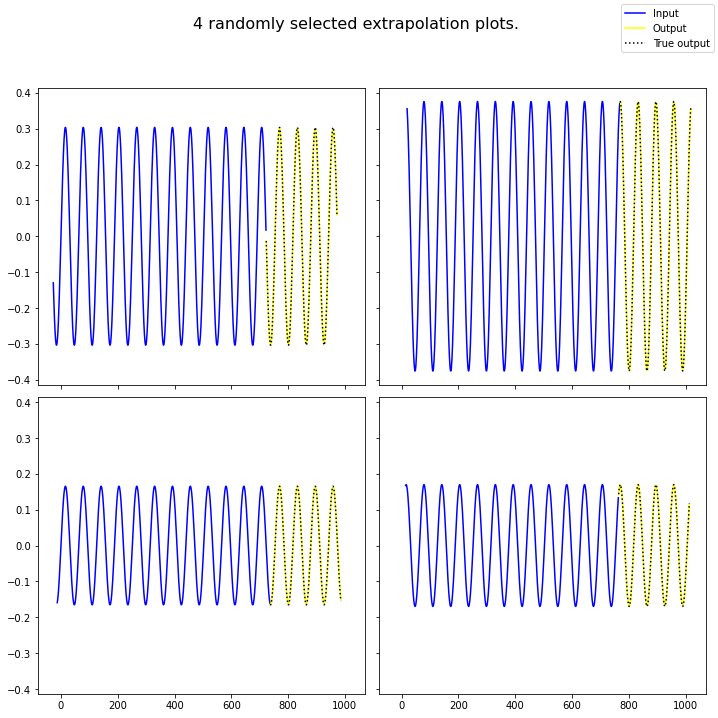

In [12]:
plot(
    x_test[:test_init],
    x_test[test_init:],
    y_test[:test_init],
    y_test[test_init:],
    y_pred_test,
    filename="test.pdf",
)